# Training Predictive Model - Face Unaligned Edition

### Import libraries

In [ ]:
import datetime, json, random, IPython, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
import torch, pytorch_lightning as pl
from ray import tune
from pytorch_lightning.loggers import TensorBoardLogger

from models import GazeDataModule, SingleModel, EyesModel, FullModel
from utils  import (
    get_config,
    tune_asha,
    get_best_results,
    save_model,
    plot_asha_param_grid,
    plot_parallel_param_loss,
    latest_tune_dir,
    _build_datamodule,
    _build_model,
    predict_screen_errors,
)

# project settings
SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")

%load_ext autoreload
%autoreload 2


### Dataset information

In [2]:
df = pd.read_csv("data/positions.csv")
region_map = np.load("data/region_map.npy").T

print(f"# of samples: {len(df)}")
coverage = np.count_nonzero(region_map > 0) / region_map.size * 100
print(f"Coverage: {coverage:.2f}% of screen surface")
print(f"Crop size: {SETTINGS['image_size']} x {SETTINGS['image_size']} px")

# of samples: 20077
Coverage: 61.84% of screen surface
Crop size: 64 x 64 px


### Data visualization

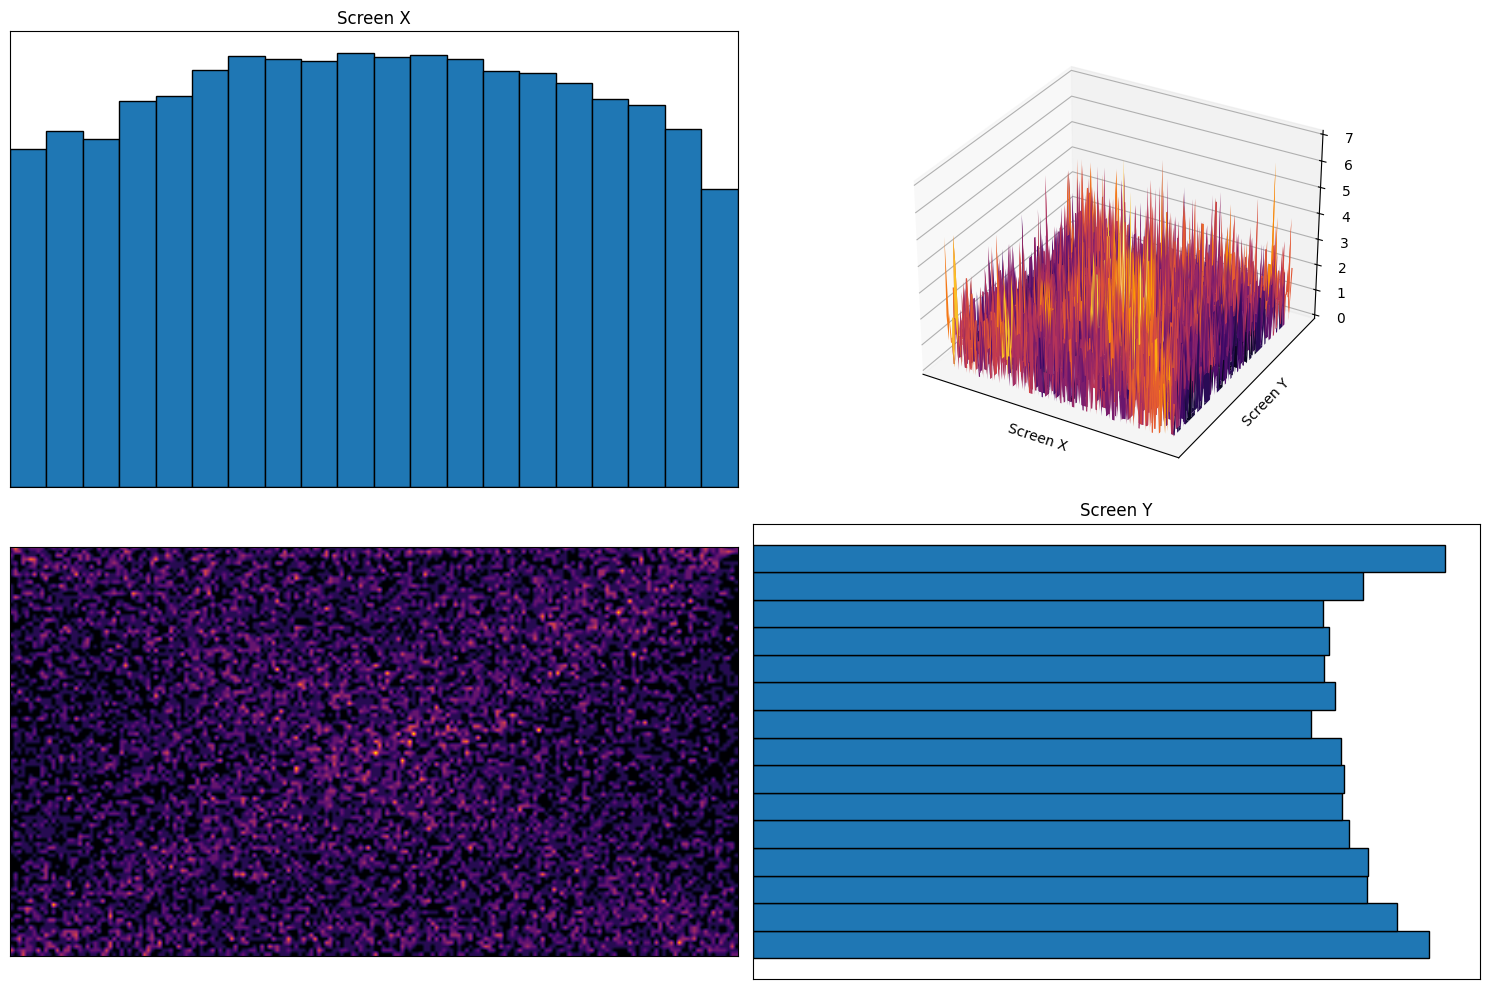

In [3]:
x = np.arange(region_map.shape[1])
y = np.arange(region_map.shape[0])
X, Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
ax.hist(df['x'], bins=20, edgecolor='k')
ax.set_title('Screen X')
ax.margins(x=0)

ax = fig.add_subplot(222, projection='3d')
ax.dist = 9
ax.plot_surface(X, Y, region_map, cmap="inferno")
ax.set_xlabel('Screen X', labelpad=-10)
ax.set_ylabel('Screen Y', labelpad=-10)

ax = fig.add_subplot(223)
ax.imshow(region_map, interpolation='bilinear', cmap="inferno")

ax = fig.add_subplot(224)
ax.hist(df['y'], bins=15, edgecolor='k', orientation='horizontal')
ax.set_title('Screen Y')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.savefig('media/images/0_data_distribution.png')
plt.show()

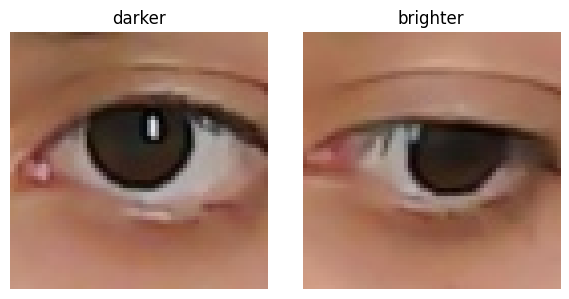

In [4]:
low_bright  = plt.imread("data/r_eye/12.jpg")
high_bright = plt.imread("data/r_eye/31.jpg")

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(low_bright);  axs[0].set_title("darker")
axs[1].imshow(high_bright); axs[1].set_title("brighter")
for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()

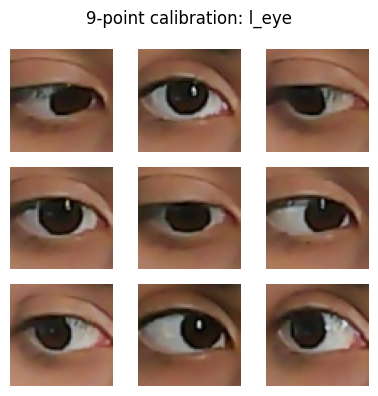

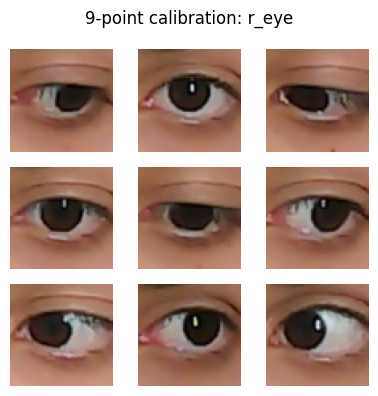

In [5]:
def plot_calibration(eye: str):
    idx = list(range(1, 10))
    imgs = [plt.imread(f"data/{eye}/{i}.jpg") for i in idx]

    fig, axs = plt.subplots(3, 3, figsize=(4, 4))
    order = [3, 6, 8, 2, 4, 7, 1, 0, 5]  # keep your original layout
    for ax, img_i in zip(axs.flat, order):
        ax.imshow(imgs[img_i])
        ax.axis("off")
    fig.suptitle(f"9-point calibration: {eye}")
    plt.tight_layout()
    plt.savefig(f"media/images/0_calibration_{eye}.png", dpi=120)
    plt.show()

plot_calibration("l_eye")
plot_calibration("r_eye")


### Fine Tuning

In [6]:
search_space = {
    "seed":  tune.randint(0, 10000),
    "bs":    tune.choice([256, 512, 1024]),
    "lr":    tune.loguniform(1e-4, 3e-3),
    "channels": tune.choice([(32, 64, 128), (48, 96, 192), (64, 128, 256)]),
    "hidden":   tune.choice([128, 256, 512]),
}

analysis = tune_asha(
    search_space   = search_space,
    train_func     = "single",  # utils infers correct trainer wrapper
    name           = "face/tune",
    img_types      = ["face"],
    num_samples    = 20,
    num_epochs     = 15,
    data_dir     = Path.cwd() / "data",
    seed           = 87,
)

2025-05-15 10:13:46,848	INFO worker.py:1852 -- Started a local Ray instance.
2025-05-15 10:13:50,489	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-05-15 10:13:50,493	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(_tune_wrapper pid=17588) Seed set to 2121
(_tune_wrapper pid=17588) Using bfloat16 Automatic Mixed Precision (AMP)
(_tune_wrapper pid=17588) GPU available: True (cuda), used: True
(_tune_wrapper pid=17588) TPU available: False, using: 0 TPU cores
(_tune_wrapper pid=17588) HPU available: False, using: 0 HPUs
(_tune_wrapper pid=17588) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_tune_wrapper pid=17588) 
(_tune_wrapper pid=17588)   | Name      | Type              | Params | Mode  | In sizes       | Out sizes     
(_tune_wrapper pid=17588) ------------------------------------------------------------------------------------------
(_tune_wrapper pid=17588) 0 | criterion | SmoothL1Loss      | 0      | train | ?              | ?             
(_tune_wrapper pid=17588) 1 | mae       | MeanAbsoluteError | 0      | train | ?              | ?             
(_tune_wrapper pid=17588) 2 | mse       | MeanSquaredError  | 0      | train | ?              | ?             
(_tune_wrapper pid=17588) 3 | rmse

Trial name,checkpoint_dir_name,date,done,hostname,iterations_since_restore,loss,mae,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
_tune_wrapper_887ea_00000,checkpoint_000014,2025-05-15_10-30-36,True,DESKTOP-B40NR52,15,221.641,222.14,127.0.0.1,17588,True,996.261,56.2877,996.261,1747297836,15,887ea_00000
_tune_wrapper_887ea_00001,checkpoint_000000,2025-05-15_10-33-40,True,DESKTOP-B40NR52,1,746.463,746.963,127.0.0.1,13272,True,169.276,169.276,169.276,1747298020,1,887ea_00001
_tune_wrapper_887ea_00002,checkpoint_000000,2025-05-15_10-36-44,True,DESKTOP-B40NR52,1,750.361,750.861,127.0.0.1,28888,True,170.355,170.355,170.355,1747298204,1,887ea_00002
_tune_wrapper_887ea_00003,checkpoint_000003,2025-05-15_10-43-31,True,DESKTOP-B40NR52,4,643.013,643.512,127.0.0.1,15720,True,395.647,71.7248,395.647,1747298611,4,887ea_00003
_tune_wrapper_887ea_00004,checkpoint_000001,2025-05-15_10-48-18,True,DESKTOP-B40NR52,2,736.823,737.323,127.0.0.1,16448,True,275.849,82.1934,275.849,1747298898,2,887ea_00004
_tune_wrapper_887ea_00005,checkpoint_000014,2025-05-15_11-07-41,True,DESKTOP-B40NR52,15,204.56,205.059,127.0.0.1,24924,True,1148.97,73.3031,1148.97,1747300061,15,887ea_00005
_tune_wrapper_887ea_00006,checkpoint_000014,2025-05-15_11-21-00,True,DESKTOP-B40NR52,15,188.855,189.355,127.0.0.1,11408,True,774.226,41.4138,774.226,1747300860,15,887ea_00006
_tune_wrapper_887ea_00007,checkpoint_000014,2025-05-15_11-39-23,True,DESKTOP-B40NR52,15,313.061,313.561,127.0.0.1,30108,True,1091.62,61.0172,1091.62,1747301963,15,887ea_00007
_tune_wrapper_887ea_00008,checkpoint_000000,2025-05-15_11-42-24,True,DESKTOP-B40NR52,1,747.082,747.582,127.0.0.1,29208,True,167.971,167.971,167.971,1747302144,1,887ea_00008
_tune_wrapper_887ea_00009,checkpoint_000001,2025-05-15_11-46-06,True,DESKTOP-B40NR52,2,643.329,643.829,127.0.0.1,25560,True,209.368,46.4975,209.368,1747302366,2,887ea_00009


(_tune_wrapper pid=17588) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face/tune_20250515-101342/887ea_00000/checkpoint_000000)
(_tune_wrapper pid=17588) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face/tune_20250515-101342/887ea_00000/checkpoint_000001)
(_tune_wrapper pid=17588) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face/tune_20250515-101342/887ea_00000/checkpoint_000002)
(_tune_wrapper pid=17588) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/face/tune_20250515-101342/887ea_00000/checkpoint_000003)
(_tune_wrapper pid=17588) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/s

Best hyperparameters:  {'seed': 6073, 'bs': 256, 'lr': 0.0012410421101904116, 'channels': (32, 64, 128), 'hidden': 512}


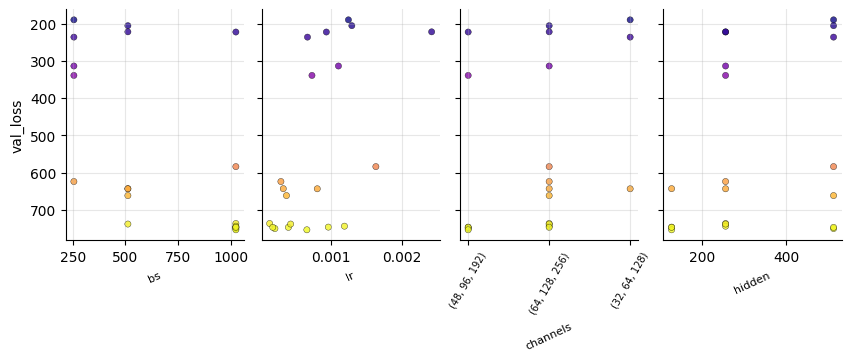

WindowsPath('media/images/1_face_explore_scatter.png')

In [7]:
plot_asha_param_grid(analysis, save_path="media/images/1_face_explore_scatter.png")

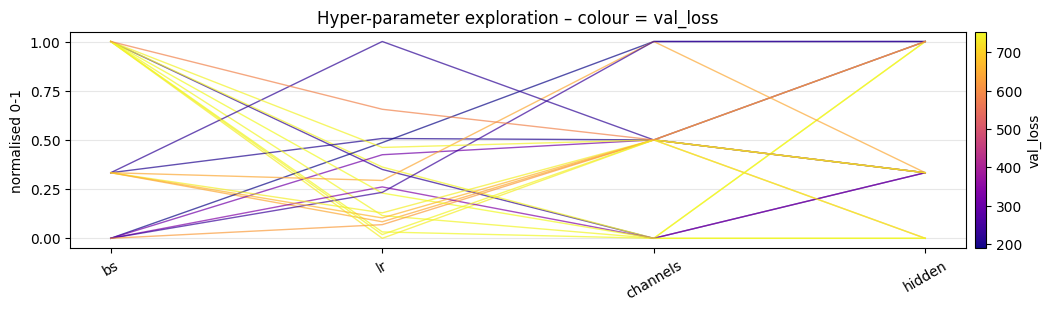

WindowsPath('media/images/1_face_explore_parallel.png')

In [8]:
plot_parallel_param_loss(analysis, save_path="media/images/1_face_explore_parallel.png")

### Tuning

In [9]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

tune_dir = Path.cwd() / "logs" / "face"
best_cfg = get_best_results(latest_tune_dir(tune_dir))
pl.seed_everything(best_cfg["seed"])

dm = GazeDataModule(
    data_dir = Path.cwd() / "data",
    batch_size = best_cfg["bs"],
    img_types = ["face"],
    seed = best_cfg["seed"],
)

model = _build_model(best_cfg, ["face"])

trainer = pl.Trainer(
    max_epochs = 100,
    accelerator = "auto",
    devices = "auto",
    precision = "bf16-mixed",           # or "16-mixed" if your GPU supports it
    logger = TensorBoardLogger(
        save_dir = Path.cwd() / "logs",
        name     = f"face/final/{start_time}",
        log_graph = True,
    ),
    callbacks = [
        pl.callbacks.ModelCheckpoint(
            filename = "best",
            monitor  = "val_loss",
            mode     = "min",
            save_last = True,
            save_top_k = 1,
        )
    ],
)

trainer.fit(model, datamodule=dm)
best_path = trainer.checkpoint_callback.best_model_path
state = torch.load(best_path, map_location="cpu", weights_only=False)  # ←
model.load_state_dict(state["state_dict"])

# save weights + config next to lightning checkpoint
out_dir = Path.cwd() / "logs" / "face" / "final" / start_time
out_dir.mkdir(parents=True, exist_ok=True)

save_model(
    model.cpu(),                   # save on CPU to shrink file size
    best_cfg,
    out_dir / "eyetracking_model.pt",
    out_dir / "eyetracking_config.json",
)

Seed set to 6073
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Best of 'c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face\tune_20250515-101342' ---

Directory: 887ea_00006
Loss: 188.86
Pixel error: 13.74
Hyperparameters...
- seed: 6073
- bs: 256
- lr: 0.0012410421101904116
- channels: [32, 64, 128]
- hidden: 512


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode  | In sizes       | Out sizes     
------------------------------------------------------------------------------------------
0 | criterion | SmoothL1Loss      | 0      | train | ?              | ?             
1 | mae       | MeanAbsoluteError | 0      | train | ?              | ?             
2 | mse       | MeanSquaredError  | 0      | train | ?              | ?             
3 | rmse      | MeanSquaredError  | 0      | train | ?              | ?             
4 | backbone  | ConvStack         | 93.5 K | train | [1, 3, 64, 64] | [1, 128, 1, 1]
5 | regressor | Sequential        | 67.1 K | train | [1, 128, 1, 1] | [1, 2]        
------------------------------------------------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.642     Total estimated model params size (MB)
26        Modules in train mode
0         Modules 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Model Evaluation

In [10]:
test_results = trainer.test(ckpt_path="best", datamodule=dm)[0]

loss = test_results["test_loss_epoch"]
mae  = test_results["test_mae_epoch"]

mse  = test_results.get("test_mse_epoch",  test_results.get("test_mse"))
rmse = test_results.get("test_rmse_epoch", test_results.get("test_rmse"))

print("────────  Test set  ────────")
print(f"MSE   : {mse:8.2f}  px²")
print(f"RMSE  : {rmse:8.2f}  px")
print(f"MAE   : {mae:8.2f}  px")
print(f"Loss  : {loss:8.2f}  (Smooth-L1)")

Restoring states from the checkpoint path at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face/final/2025-May-15 12-48-48\version_0\checkpoints\best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\face/final/2025-May-15 12-48-48\version_0\checkpoints\best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         38.75514602661133
     test_mae_epoch          39.25187301635742
        test_mse             2877.44482421875
        test_rmse           53.406436920166016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
────────  Test set  ────────
MSE   :  2877.44  px²
RMSE  :    53.41  px
MAE   :    39.25  px
Loss  :    38.76  (Smooth-L1)


  0%|          | 0/20077 [00:00<?, ?it/s]

Average error: 60.29px over 2008 samples


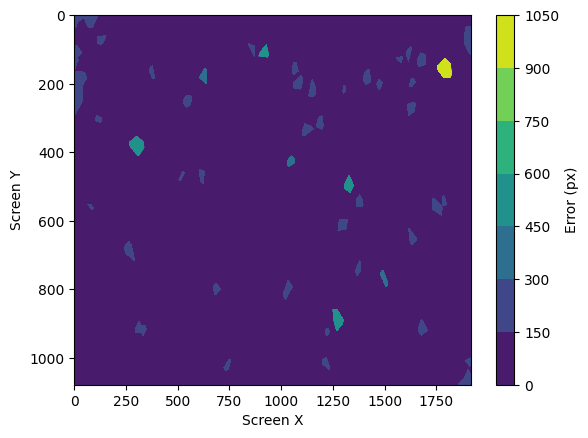

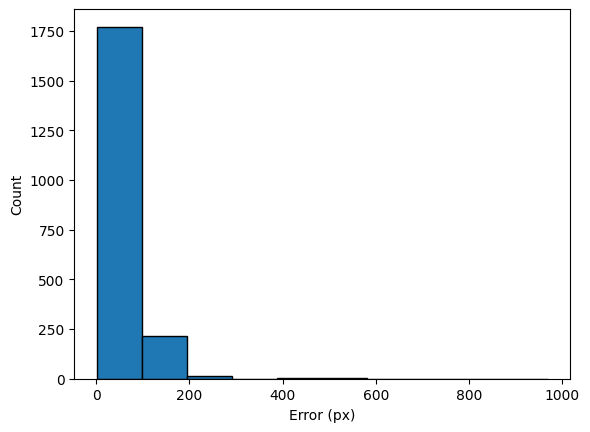

In [11]:
predict_screen_errors(
    "face",
    path_model  = out_dir/"eyetracking_model.pt",
    path_config = out_dir/"eyetracking_config.json",
    path_plot   = out_dir/"error_heatmap_face.png",
    path_errors = out_dir/"errors.npy",
    steps       = 10,
)